# Monte Carlo y el ensamble canónico

### $\pi$ con Monte-Carlo

Antes de comenzar con el tema realmente, quiero aclarar algunas cosas que vi que algunos puntos. Monte-Carlo es un principado de Francia donde hay un gran casino, así que se usó el nombre de "Métodos de Monte Carlo" a cualquiera que usara generadores de números aleatorios para calcular algo. 

Muy frecuentemente se introducen los Métodos de Monte-Carlo vía el cálculo de $\pi$, donde se pone un cuadrado de lado 2 y dentro se pone un círculo de radio 1. Después se lanzan disparos y se cuenta el número de los que cayeron dentro del círculo y la proporción multiplicada por 4 da más o menos $\pi$ 

#### Método de disparos

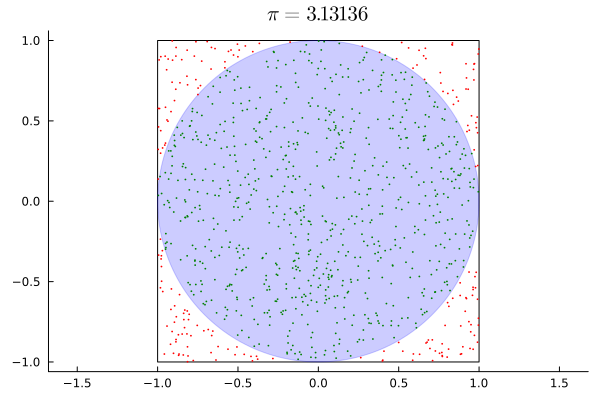

In [38]:
using Plots, LinearAlgebra, LaTeXStrings

N = 100_000
function circulo!(x, r; kargs...)
    puntos = [(r*cos(θ)+x[1],r*sin(θ)+x[1]) for θ in 0:π/100:2π+π/101]
    plot!(puntos; kargs...)
end
plot([-1,1,1,-1,-1], [-1,-1,1,1,-1], color = :black, aspect_ratio = 1, key = false)
circulo!([0,0], 1, color = :blue, fill = true, alpha = 0.2, grid = false)
contador = 0
for i in 1:N
    x = (-2*rand().+1, -2*rand().+1)
    color = :red
    if norm(x)< 1
        contador += 1
        color = :green
    end
    if i<1001
        scatter!(x, color = color, ms = 1, markerstrokewidth = 0)
    end 
end
plot!(title = L"\pi = %$(4*contador/N)") 

A veces se introduce después la idea de integral igual que esto de los disparos. Esa es la forma "chafa" de hacerlo y creo que sólo tiene como propósito introducir la idea de números aleatorios en la comptadora. Creo que varios profesores no explican cómo calcular realmente integrales con Monte-Carlo porque pues se requiere de probabilidad. Nosotros ya lo vimos en este curso, así que sólo hare una pequeña recordadita:  


### Integral de Monte-Carlo

La idea de la integral de Monte-Carlo es usar la definición de valor esperado:

$$\langle X \rangle = \int_{-\infty}^{\infty} x \rho_X(x)dx $$

Y también sabemos que:

$$\langle f(X) \rangle = \int_{-\infty}^{\infty} f(x)\rho_X(x) dx$$

así que si yo pongo $\rho_X(x)$ como una variable aleatoria homogenea en un intervalo $[a,b]$, tendré qué: 

$$\langle f(X) \rangle = \frac{1}{b-a}\int_{a}^{b} f(x) dx$$

In [2]:
∫(f, a,b, n = 1000) = (b-a)*sum(f((b-a)*rand()+a) for i in 1:n)/n
    

∫ (generic function with 2 methods)

In [3]:
f(x) = x^3
∫(f, 3, 5, 100000), 1/4 * (5^4 - 3^4)

(135.638658529869, 136.0)

In [4]:
f(x) = sqrt(1-x^2)
4*∫(f, 0, 1, 1_000_000)

3.1424219274664162

Eso es lo que tiene que ver con integrales de Monte-Carlo. Pero cuando hablamos de algoritmos de Monte-Carlo en física, no nos referimos para nada a estas integrales. Nos referimos a hacer simulaciones usando números aleatorios. De alguna forma es también resolver una integral en muchas dimensiones, pero la idea de fondo es mucho más física. 

### Solución de problemas en física estadística y sistemas complejos

Lo que queremos es resolver un problema de muchas partículas, es decir, donde podemos usar uno de nuestros ensambles. En este caso tenemos generalmente 2 posibles caminos o un tercero campechaneando los 2 caminos principales. 

Posibles caminos para resolver los problemas en FE:

1. Idealizando y resolviendo analíticamente

Es por supuesto lo que más peso le daremos en el curso. Cuando los sistemas son ideales, es decir, sin interacciones, normalmente podemos resolverlos completamente, así como el gas ideal o el sólido paramagnético. En esos mismos problemas podemos agregar algunas cosas, como que las moléculas no sean monoatómicas, o que estén cargadas eléctricamente. Son problemas con algún interés y a veces mucho interés, pero tienen grandes limitaciones. Normalmente lo más interesante ocurre cuando agregamos intereacciones. En ese caso frecuentemente el problema se vuelve rápidamente súper difícil. Hay algunos que aún así se pueden resolver analíticamente, pero típicamente lo que uno hace es más bien aproximar. La versión más famosa es la teoría de campo medio, que básicamente transforma el problema de interacción en un potencial externo promedio y así el problema nuevamente se vuelve un problema de partículas ideales. Eso ayuda si las interacciones no son muy grandes, si las fluctuaciones por las interacciones tampoco y si podemos estimar bien ese campo promedio. Es todo un arte cómo hacer esas estimaciones. 

Aunque ya con todas las técnicas analíticas que hay podemos resolver una buena gama de problemas, aún son muchos más los que la aproximación analítica ideal no es suficiente. Ahí entra la segunda forma de resolver los problemas. 

2. Aproximando la solución con una simulación numérica

Hay 3 formas de hacer las simulaciones. La primera es dinámica molecular o por agentes, que básicamente es poner $N$ partículas con sus respectivos potenciales externos y de interacción con otras partículas. Esto nos lleva a resolver ecuaciones diferenciales (los hamiltonianos) y con ellos obtenemos el ensamble microcanónico, que promediamos no en el espacio, sino en el tiempo. Es lo más realista de todas, ni siquiera requiere que estemos en equilibrio o que el sistema sea ergódico; pero también suele ser lo más difícil de programarse y resolver $N$ ecuaciones diferenciales simultanias para largos periodos de tiempo suele además ser muy tardado. Se puede hacer eficiente, pero no es trivial. Aún así, en algunos casos es lo mejor. Pero es difícil. 

La segunda técnica es muy parecida, pero ya incluye la temperatura. Se llama dinámica Browniana. La veremos después con cuidado, tanto teórica, como numéricamente, pero les adelanto que se trata de resolver ecuaciones diferenciales estocásticas, es decir, donde las funciones son funciones de variables aleatorias. Analíticamente implica que uno tiene que estar sacando promedios. Las técnicas son muy bonitas. Numéricamente implica simplemente poner un generador de números aleatorios adecuado en el lugar donde se ponían números en los métodos típicos. Lo veremos. 

La última técnica es la de Monte-Carlo. Hay todas las versiones de Monte-Carlo, para cada ensamble, pero la versión más natural es la del ensamble canónico. Es la que veremos por ahora. 

### Proceso de Markov

Un proveso de Markov es una generalización de un caminante aleatorio. ¿Qué tiene de especial el caminante aleatorio? Que su posición en el tiempo $t$ sólo depende de su posición en el tiempo $t-1$. Un proceso de Markov es justamente eso. En principio, la posición de un caminante podría depender de toda su historia. Es el caso de las decisiones de las personas, pero también de algunos materiales, como los materiales vítreos. La temperatura de transición de un vídrio depende de la forma en la que se llevó al estado vítreo. También los materiales con memoria cumplen con esto. Han visto uno?

Un proceso de Markov, en cambio sólo depende de la posición instantes antes, es decir: 

$$P(X_{n+1}=x\mid X_1=x_1, X_2=x_2, \ldots, X_n=x_n) = P(X_{n+1}=x\mid X_n=x_n)$$

Entonces, no siempre los sistemas siguen un proceso de Markov, pero sí es común y asumimos que si un sistema es suficientemente caótico, entonces seguirá un proceso de Markov. Pero insisto, no siempre se siguen procesos de Markov y por lo tanto no siempre funcionan esta clase de simulaciones. 

Ahora bien, dado que asumiremos un proceso de Markov, entonces el nos basta con tener las probabilidades de transición: 



probabilidades de transición del estado $x_i$ al estado $x_j$.

$$P(x_i| x_j)$$

Si tenemos estas propiedades, podemos calcular la trayectoria del proceso. Recordemos que queremos estudiar sistemas en equilibrio. En este caso, estarémos en un estado estacionario, es decir, cuando la cantidad de flujo del estado $x_i$ al estado $x_j$ sea igual que el flujo del estado $x_j$ al estado $x_i$. Esta condición no es 100% necesaria, lo que permite que estas simulaciones también sirvan para estudiar estados fuera de equilibrio, pero por ahora vamos a asumir que llegamos a un estado estacionario, es decir: 

$$ P(x_i|x_j)\rho(x_j) = P(x_j|x_i)\rho(x_i)$$

donde $\rho(x_i)$ es la densidad de probabilidad de encontrarnos en el estado $x_i$. Esta condición de equilibrio de flujos se conoce como "Balance detallado" y tiene que cumplirse en el equilibrio. 

Otra característica del equilibrio es que sólo haya un estado estacionario, pues si hubiera varios, significa que dependería de la historia en qué estado estacionario nos encontramos. Esto es importante, el equilibrio no sólo significa un estado estacionario, además debe cumplirse que sea único, que no dependa de la historia del sistema. Esta característica se cumple inmediatamente por tratarse de un proceso de Markof. 

## Ensamble canónico y cadenas de Markov

Si tuviéramos el ensamble microcanónico, la probabilidad $\rho(x)$ sería $1/\Omega$, por lo que llegamos simplemente a que la probabilidad de moverse de un estado a otro es igual que la de moverse del otro a uno. Esto no nos sirve de mucho. Simplemente llegamos a lo que ya sabíamos. 

En el ensamble canónico la cosa se vuelve más interesante. $\rho$ es: 

$$ \rho(x_i) = P(x_i) = \frac{e^{-H/kT}}{Z}$$

Calcular $Z$ podría ser horriblemente difícil (aunque hay maneras), pero por suerte, $\rho$ aparece de ambos lados de la ecuación, así que podemos escribir más bien: 

$$ \frac{P(x_i|x_j)}{ P(x_j|x_i)} =\frac{\rho(x_i)}{\rho(x_j)} = e^{-\beta(H_i-H_j)} = e^{-\beta\Delta H}$$

$P(x_i|x_j)$ es la probabilidad de que nuestro sistema se mueva de un estado (un punto del espacio fase) a otro estado (otro punto del espacio fase). Recordemos que esa trayectoria no necesariamente corresponde con una trayetoria posible, pues podemos promediar en el espacio fase en vez de promediar en el tiempo. Dicho de otra forma, queremos encontrar las $P(x_i|x_j)$ que después de un número de cambios de estado suficientemente grande, nos arroje una densidad de estados del espacio fase $\rho(x)$. 

Para tratar de reducir el problema y verlo algorítmicamente, dividimos $P(x_i|x_j)$ en 2 etapas. La primera proponemos un cambio del estado $x_j$ a uno cualquiera $x_i$. Eso tiene una probabilidad de ocurrir que podemos asumir homogenea o al menos simétrica. Luego, aceptamos esa propuesta de cambio con probabilidad $A(x_i|x_j)$. Por lo tanto: 

$$ \frac{P(x_i|x_j)}{ P(x_j|x_i)} =\frac{A(x_i|x_j)}{ A(x_j|x_i)} = \frac{g(x_j|x_i)}{ g(x_i|x_j)}e^{-\beta\Delta H} =e^{-\beta\Delta H}$$

Podemos usar cualquier probabilidad de acceptación que cumpla con esta condición y con la condición de ser una probabilidad, es decir, de estar entre $0$ y $1$. La más directa que cumple con esta condición es: 

$$A(x_i|x_j) = \min(1, e^{-\beta\Delta H})$$

Esta condición cumple con estar entre 0 y 1. Ahora bien, si  $\Delta H$ es negativo, entonces $A(x_i|x_j) = 1$ y $A(x_j|x_i) = e^{\beta \Delta H}$ y por lo tanto, se cumple la relación. Si $\Delta H$ es positivo, entonces  $A(x_j|x_i) = 1$ y $A(x_i|x_j) = e^{-\beta \Delta H}$ que también cumple con la relación. 

## Algoritmo de Metrópolis

Esa propuesta de aceptación en la probabilidad es parte del algoritmo de metrópolis. No es la única versión. A veces para estudiar estados fuera de equilibrio es más acertado elegir otras probabilidades y también a veces otras probabilidades de aceptación llevan al equilibrio más rápidoamente.

La otra parte es cómo se da la parte de proponer un cambio. En principio un cambio puede ser de cualquier tipo. Si tenemos un gas de partículas, por ejemplo, un cambio puede ser mover todas o mover la mitad. En el algoritmo de Metrópolis los cambios se hacen de uno en uno. Esto limita bastante el algoritmo y en algunos casos no se puede acceder a todos los estados del sistema de esta forma, por lo que es necesario hacer propuestas de cambios de más de un movimiento a la vez; sin embargo, en una gran cantidad de problemas es suficiente este algoritmo. Escribo el algoritmo tal cual: 

Dado $H$ y una configuración $x_i$ y una temperatura $kT$

1. Se selecciona un elemento de la configuración al asar, el cual se copia y modifica al azar para generar una configuración $x_j$. 
2. Se calcula $\Delta H$ y con ello $A(x_i|x_j)  = \min(1, e^{-\beta\Delta H})$. 
3. Se genera un número aleatorio $r$ con distribución uniforme entre $0$ y $1$. Si $r< A(x_i|x_j)$, se actualiza la configuraciòn a $x_j$. en otro caso se deja igual. 
4. Se repiten los pasos $2$ y $3$ $N$ veces y se arroja la nueva configuración.  


Vamos a programar esta versión general de algoritmo!

In [40]:
function metropolis_1(ΔH, σ, modificador!; β = 1, parametros...)
    n = length(σ)
    i = rand(1:n)
    x = copy(σ[i])
    x = modificador!(x, i, σ)
    dH = ΔH(x,i, σ; parametros...)
    p = exp(-β*dH)
    if rand()< p
        σ[i] = copy(x)
    end
    return σ
end

function metropolis(ΔH, σ, modificador!; N = 1, β = 1,  parametros...)
    for i in 1:N
        σ = metropolis_1(ΔH, σ, modificador!; β = β, parametros...)
    end
    return σ
end


metropolis (generic function with 1 method)

Ahora veamos un ejemplo concreto. Por supuesto, necesitamos para ello especificar la función $\Delta H$ y el modificador!. 

Por ejemplo, el sólido paramagnético. 

In [6]:
H(σ; B = 1, μ = 1) = -B*μ*sum(σ)
ΔH(x, i, σ; B = 1, μ = 1) =-2B*μ*x

ΔH (generic function with 1 method)

In [7]:
function modificador!(x, i, σ) 
    x = -x
end

modificador! (generic function with 1 method)

In [8]:
N = 1000
βs = -10:0.0101:10
M = zeros(length(βs))
E = zeros(length(βs))
i = 0
for β in βs
    i += 1
    σ = rand([-1,1], N )
    σ = metropolis(ΔH, σ, modificador!, N = 10N, β = β, B = 1, μ = 1)
    M[i] = sum(σ)/N
    E[i] = H(σ, B = 1, μ = 1)
end 

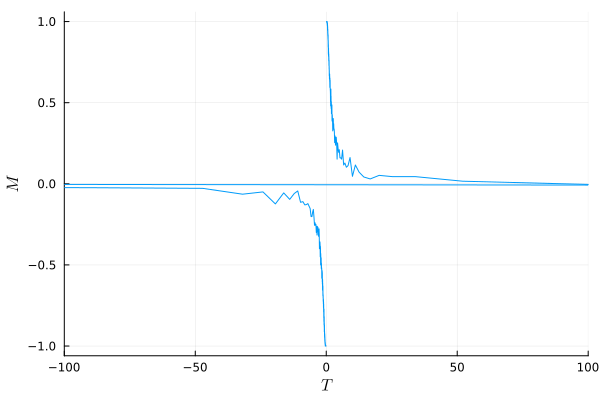

In [9]:
plot([1/β for β in βs], M, key = false)
plot!(xlabel = L"T", ylabel = L"M")
plot!(xlim = (-100,100))

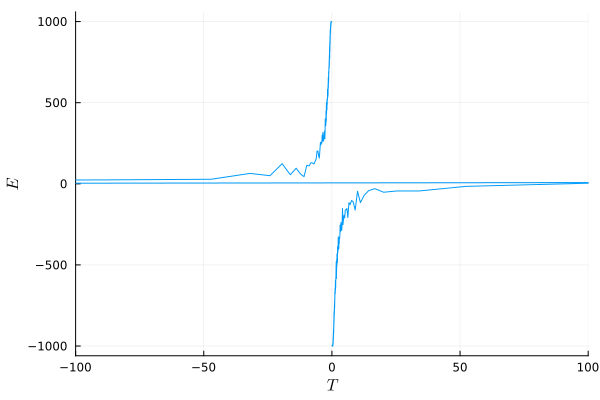

In [10]:
plot([1/β for β in βs], E, key = false)
plot!(xlabel = L"T", ylabel = L"E")
plot!(xlim = (-100,100))

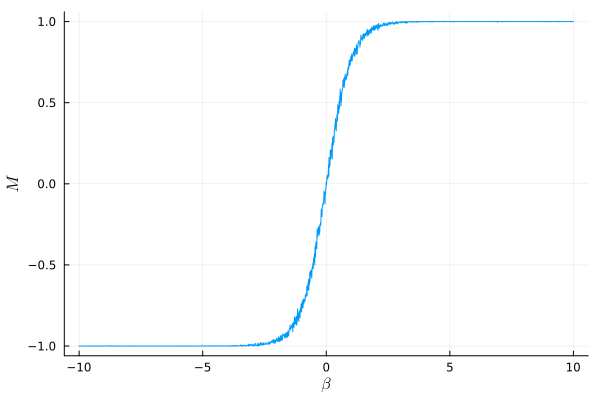

In [11]:
plot([β for β in βs], M, key = false)
plot!(xlabel = L"β", ylabel = L"M")

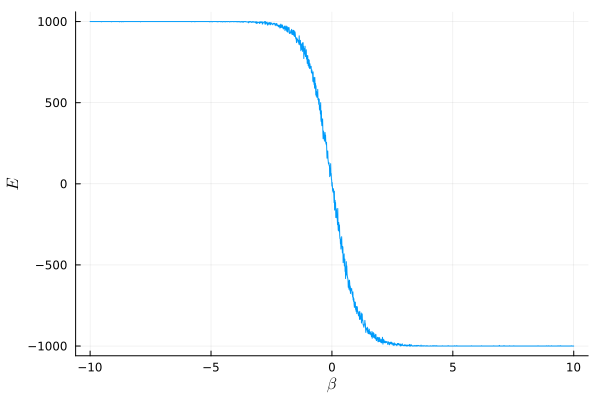

In [12]:
plot([β for β in βs], E, key = false)
plot!(xlabel = L"β", ylabel = L"E")

Ya hemos dicho que $\beta$ es la variable conjugada correcta. Ahora vemos que ademas usar la $\beta$ en lugar de $T$ es también más natural para analizar algunos resultados. En general los que tienen temperaturas negativas es mejor analizarlos con $\beta$. En ese caso hay continuidad. Ahora, aprovechemos las formulitas que obtuvimos: 

Recuerden: 

$$\Rightarrow C_v = \frac{\sigma^2(E)}{k_B T^2}  $$  

Cara calcularlo vamos a hacer promedios y de paso obtendremos $M$ y $E$ más finos. Para esto, repetimos la simulación y después hacemos algunos pasos de simulación extra para promediar!

In [13]:
N = 1000
n = 100
βs = -10:0.0101:10
Mp = zeros(length(βs))
Ep = zeros(length(βs))
σE = zeros(length(βs))
σM = zeros(length(βs))
i = 0
for β in βs
    E = [0.0 for j in 1:1000]
    M = [0.0 for j in 1:1000]
    i += 1
    σ = rand([-1,1], N )
    σ = metropolis(ΔH, σ, modificador!, N = 10N, β = β, B = 1, μ = 1)
    for j in 1:n
        σ = metropolis(ΔH, σ, modificador!, N = 100, β = β, B = 1, μ = 1)
        E[j] = H(σ, B = 1, μ = 1)
        M[j] = sum(σ)/N
    end
    Ep[i] = sum(E)/n
    Mp[i] = sum(M)/n
    σE[i] = sum(E.^2)/n - Ep[i]^2
    σM[i] = sum(M.^2)/n - Mp[i]^2
end 

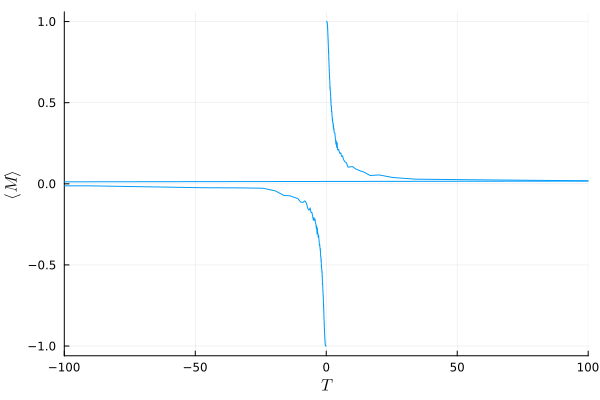

In [14]:
plot([1/β for β in βs], Mp, key = false)
plot!(xlabel = L"T", ylabel = L"\langle M \rangle")
plot!(xlim = (-100,100))

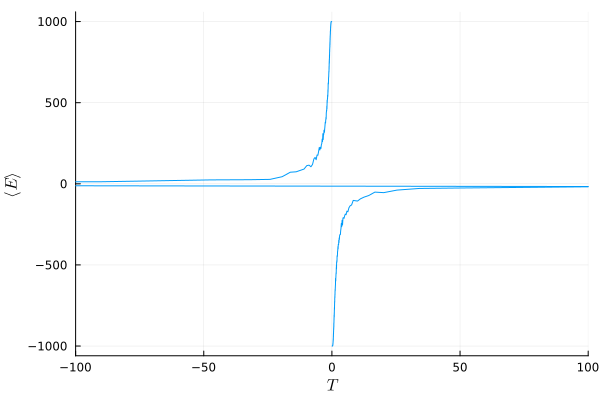

In [15]:
plot([1/β for β in βs], Ep, key = false)
plot!(xlabel = L"T", ylabel = L"\langle E \rangle")
plot!(xlim = (-100,100))

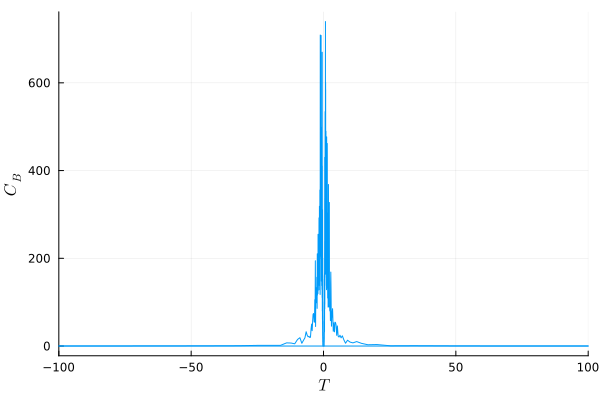

In [16]:
plot([1/β for β in βs], σE.*βs.^2, key = false)
plot!(xlabel = L"T", ylabel = L"C_B")
plot!(xlim = (-100,100))

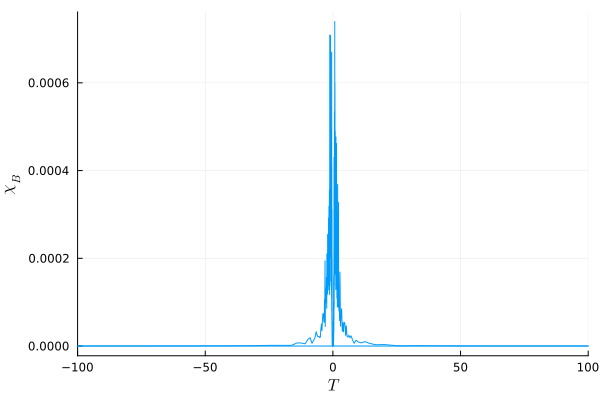

In [17]:
plot([1/β for β in βs], σM.*βs.^2, key = false)
plot!(xlabel = L"T", ylabel = L"\chi_B")
plot!(xlim = (-100,100))

Las gráficas no son las más bonitas del mundo, pero porque hicimos el promedio sólo con 1000 casos. Normalmente necesitaríamos al menos 10 veces más para ser finos. Igual ya se reconoce que no hay realmente una transición de fase, excepto quizá en el 0 absoluto, pero como el 0 absoluno no se puede alcanzar, pues no hay dicha transición en ningún momento. Hay por ahí un piquito del que uno podría dudar, pero no es simétrico, así que uno puede adivinar que es parte del ruido. 

Antes de pasar al siguiente modelo, déjenme dibujar el sólido: 

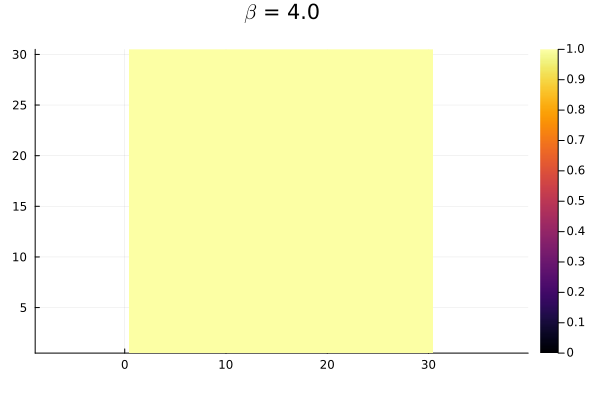

In [18]:
N = 900
n = 100
βs = -4:0.04:4
Mp = zeros(length(βs))
Ep = zeros(length(βs))
σE = zeros(length(βs))
σM = zeros(length(βs))
i = 0
for β in βs
    E = [0.0 for j in 1:1000]
    M = [0.0 for j in 1:1000]
    i += 1
    σ = rand([-1,1], N )
    σ = metropolis(ΔH, σ, modificador!, N = 10N, β = β, B = 1, μ = 1)
    σr = reshape(σ, 30,30)
    heatmap(1:30, 1:30, σr, show = :ijulia, title = L"$\beta$ = %$β", aspect_ratio = 1)

end 

Ahora haremos un problema más interesante, que por ahora sólo lo resolveré, numéricamente, para que todos sepan de él y lo veremos más a detalle en la siguiente parte del curso, partículas interactuantes. Y aquí tengo una pregunta...

## Modelo de Ising

El modelo de Ising en realidad es de Ising-Lenz. Lenz era el profesor, Ising el doctorante. Lenz le propuso el modelo a Ising como tema de doctorado y le dejó el reconocimiento 100%, aunque en realidad Ising fue quien lo propuso, así que es justo darle crédito. Normalmente es un poco al revés, el profesor se queda con todo el crédito. 

La idea es tratar de modelar un sólido ferromagnético. Una idea muy similar al paramagnético, donde los espines apuntan arriba o abajo, pero en vez de que sean partículas independientes, hay una energía de enlace que depende de los espines. 

$$H(\sigma, B, J) = -B\sum \sigma_i - \sum J_{i,j} \sigma_i\sigma_j$$

La primera parte es justamente la parte paramagnética, la segunda tiene que ver con la interacción entre las partículas y $J_{i,j}$ sería algo así como la energía de formar un enlace entre la partícula $i$ y la $j$. El modelo de Ising considera sólo las interacciones a primeros vecinos y considera entonces que todas las $J$'s son iguales, así que: 

$$H(\sigma, B, J) = -B\sum \sigma_i - \frac{1}{2} J\sum_{\langle i,j\rangle}  \sigma_i\sigma_j$$

Aquí $\langle i,j\rangle$ no es un promedio, sino que decimos que la suma es sobre los vecinos, es decir, es una doble suma, sobre todos los $i$'s, pero los $j$'s son sólo los que son vecinos de $i$. Es decir, ahora la $H$ depende también de la estructura del cristal. Ahora $\sigma$ es una red completa. 

In [41]:
function vecinoscuadrados(L)
    filas = [floor(Int,(i-1)/L) for i in 1:L^2]
    [[filas[i]*L+mod1(i-1,L), filas[i]*L+mod1(i+1,L), mod(filas[i]-1, L)*L+mod1(i,L),mod(filas[i]+1, L)*L+mod1(i,L)]
        for i in 1:L^2]
end
vecinoscuadrados(3)

9-element Vector{Vector{Int64}}:
 [3, 2, 7, 4]
 [1, 3, 8, 5]
 [2, 1, 9, 6]
 [6, 5, 1, 7]
 [4, 6, 2, 8]
 [5, 4, 3, 9]
 [9, 8, 4, 1]
 [7, 9, 5, 2]
 [8, 7, 6, 3]

In [42]:
function H(σ; B = 0, J = 1, vecinos = vecinoscuadrados(floor(Int, sqrt(length(σ))))) 
    -B*sum(σ)-0.5*J*sum(σ[j]*σ[i] for i in 1:length(σ) for j in vecinos[i])
end
    
function ΔH(x, i, σ; B = 0, J = 1, vecinos = vecinoscuadrados(floor(Int, sqrt(length(σ))))) 
    -2(B*x+J*x*sum(σ[vecinos[i]]))
end

ΔH (generic function with 1 method)

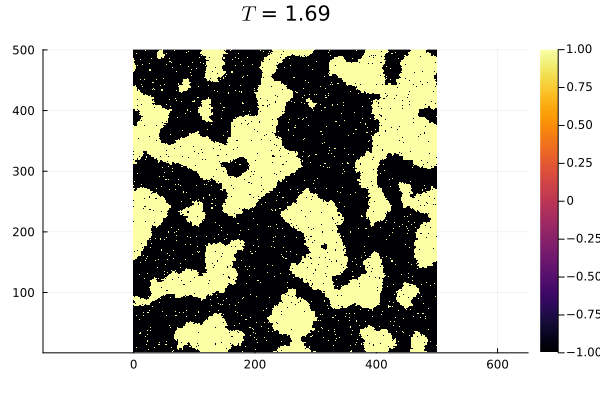

LoadError: InterruptException:

In [43]:
L = 500
N = L^2
Ts = 2.6:-0.01:0
Mp = zeros(length(Ts))
Ep = zeros(length(Ts))
σE = zeros(length(Ts))
σM = zeros(length(Ts))
i = 0
vecinos = vecinoscuadrados(L)
σ = rand([-1,1], N)
for T in Ts
    E = [0.0 for j in 1:1000]
    M = [0.0 for j in 1:1000]
    i += 1
    σ = metropolis(ΔH, σ, modificador!, N = 10N, β = 1.0 ./T, B = 0.0, J = 1, vecinos = vecinos)
    σr = reshape(σ, L,L)
    heatmap(1:L, 1:L, σr, show = :ijulia, title = L"$T$ = %$T", aspect_ratio = 1)

end 

In [27]:
L = 50
N = L^2
vecinos = vecinoscuadrados(L)
n = 1000
Ts = 4:-0.01:0
Mp = zeros(length(Ts))
Ep = zeros(length(Ts))
σE = zeros(length(Ts))
σM = zeros(length(Ts))
i = 0
σ = rand([-1,1], N )
for T in Ts
    @show T
    E = [0.0 for j in 1:n]
    M = [0.0 for j in 1:n]
    i += 1
    σ = metropolis(ΔH, σ, modificador!, N = 500N, β = 1.0 ./T, B = 0.001, J = 1, vecinos = vecinos)
    for j in 1:n
        σ = metropolis(ΔH, σ, modificador!, N = N, β = 1.0 ./T, B = 0.001, J = 1, vecinos = vecinos)
        E[j] = H(σ, B = 0, J = 1, vecinos = vecinos)
        M[j] = sum(σ)/N
    end
    Ep[i] = sum(E)/n
    Mp[i] = sum(M)/n
    σE[i] = sum(E.^2)/n - Ep[i]^2
    σM[i] = sum(M.^2)/n - Mp[i]^2
end 

T = 4.0
T = 3.99
T = 3.98
T = 3.97
T = 3.96
T = 3.95
T = 3.94
T = 3.93
T = 3.92
T = 3.91
T = 3.9
T = 3.89
T = 3.88
T = 3.87
T = 3.86
T = 3.85
T = 3.84
T = 3.83
T = 3.82
T = 3.81
T = 3.8
T = 3.79
T = 3.78
T = 3.77
T = 3.76
T = 3.75
T = 3.74
T = 3.73
T = 3.72
T = 3.71
T = 3.7
T = 3.69
T = 3.68
T = 3.67
T = 3.66
T = 3.65
T = 3.64
T = 3.63
T = 3.62
T = 3.61
T = 3.6
T = 3.59
T = 3.58
T = 3.57
T = 3.56
T = 3.55
T = 3.54
T = 3.53
T = 3.52
T = 3.51
T = 3.5
T = 3.49
T = 3.48
T = 3.47
T = 3.46
T = 3.45
T = 3.44
T = 3.43
T = 3.42
T = 3.41
T = 3.4
T = 3.39
T = 3.38
T = 3.37
T = 3.36
T = 3.35
T = 3.34
T = 3.33
T = 3.32
T = 3.31
T = 3.3
T = 3.29
T = 3.28
T = 3.27
T = 3.26
T = 3.25
T = 3.24
T = 3.23
T = 3.22
T = 3.21
T = 3.2
T = 3.19
T = 3.18
T = 3.17
T = 3.16
T = 3.15
T = 3.14
T = 3.13
T = 3.12
T = 3.11
T = 3.1
T = 3.09
T = 3.08
T = 3.07
T = 3.06
T = 3.05
T = 3.04
T = 3.03
T = 3.02
T = 3.01
T = 3.0
T = 2.99
T = 2.98
T = 2.97
T = 2.96
T = 2.95
T = 2.94
T = 2.93
T = 2.92
T = 2.91
T = 2.9
T = 2.89
T = 

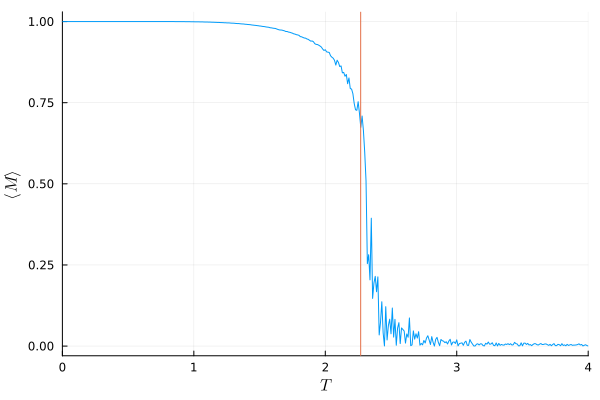

In [28]:
T₀(J) = 2J/(log(1+sqrt(2)))
plot(Ts, abs.(Mp), key = false)
plot!(xlabel = L"T", ylabel = L"\langle M \rangle")
plot!(xlim = (0,4))
vline!([T₀(1)])

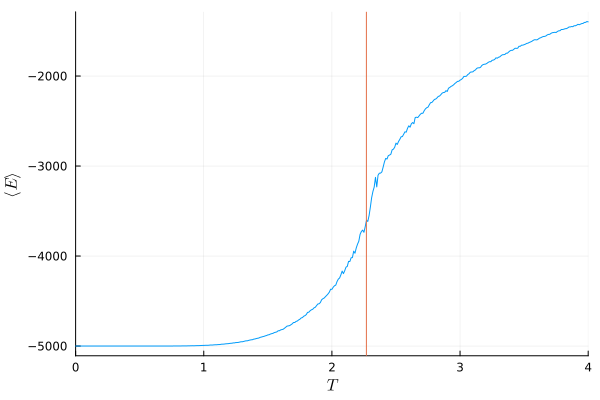

In [29]:
plot(Ts, Ep, key = false)
plot!(xlabel = L"T", ylabel = L"\langle E \rangle")
plot!(xlim = (0,4))
vline!([T₀(1)])

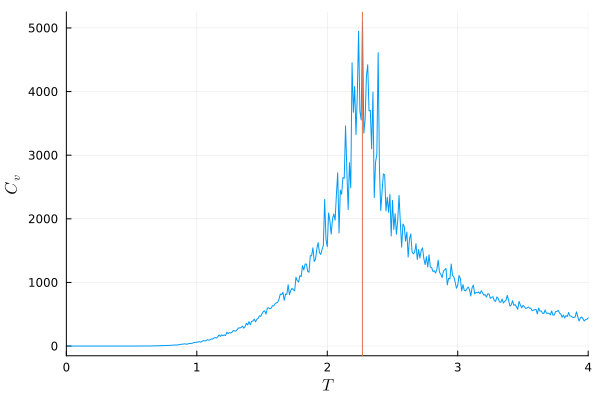

In [30]:
plot(Ts, σE./Ts.^2, key = false)
plot!(xlabel = L"T", ylabel = L"C_v")
plot!(xlim = (0,4))
vline!([T₀(1)])

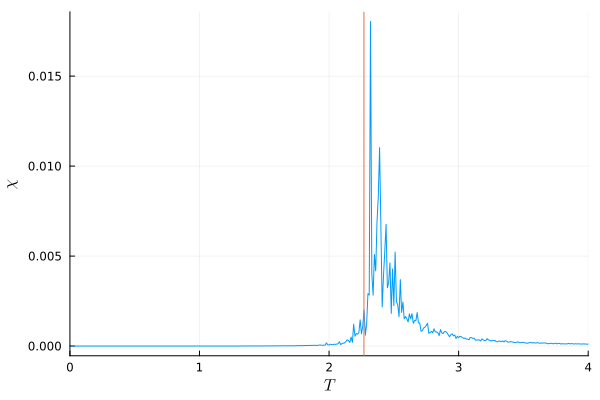

In [31]:
plot(Ts, σM./Ts.^2, key = false)
plot!(xlabel = L"T", ylabel = L"\chi")
plot!(xlim = (0,4))
vline!([T₀(1)])